<a href="https://colab.research.google.com/github/pcarbomestre/SAR-VesselDetection-FisheriesMonitoring/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

## Importing the libraries

In [ ]:
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
import xml.etree.ElementTree as ET
import shutil
import pickle
ia.seed(1)
%matplotlib inline

## Setup

Set working directory and path to the different data subfolders.

In [ ]:
# Global paths (Using SSDD default folder structure)
root = '/Users/polcarbo/Documents/Documents/2023/UOC/PEC/PEC2/SSDD_pcarbomestre_2.0/'
annotations_path = 'data/annotations/'
images_path = 'data/ssdd_images/'
dest = 'data/datasets/'
imagesets = 'data/imagesets/'
# set working directory
os.chdir(root)

Create subfolders to store the corresponding annotations and images

In [ ]:
# RUN ONLY ONCE
os.mkdir(dest + "train/")
os.mkdir(dest + "test/")
os.mkdir(dest + "test_offshore/")
os.mkdir(annotations_path + "no_vessel/")
os.mkdir(annotations_path + "vessel/")
os.mkdir(images_path + "no_vessel/")
os.mkdir(images_path + "vessel/")

## Filtering data

Separate .xml files with no ships annotated with those ones containing vessels.

In [ ]:
# RUN ONLY ONCE
# Move xml with no annotations to 'no_vessel' folder
# if xml file does not contain <object> then move to 'no_vessel' folder
# else move to 'vessel' folder
def move_xmls():
    for file in glob.glob(annotations_path + "*.xml"):
        tree = ET.parse(file)
        root = tree.getroot()
        if len(root.findall('object')) == 0:
            shutil.move(file,annotations_path + "no_vessel/")
        else:
            shutil.move(file,annotations_path + "vessel/")

# execute function
move_xmls()

Check whether there is any remaining .xml file with ships annotated.

In [ ]:
# Count how many times the word ship appears in all the xml file inside no_vessel folder
def check_count_ships():
    count = 0
    for file in glob.glob(annotations_path + "no_vessel/*.xml"):
        tree = ET.parse(file)
        root = tree.getroot()
        for child in root:
            if child.tag == 'object':
                if child[0].text == 'ship':
                    count += 1
    return count
# execute function
check_count_ships()

0

Evaluate the number of vessels anotated in the selected images.

In [ ]:
# Count the number of times that 'ship' appers among all xml files
def count_ships():
    count = 0
    for file in glob.glob(annotations_path + "vessel/*.xml"):
        tree = ET.parse(file)
        root = tree.getroot()
        for obj in root.findall('object'):
            if obj.find('name').text == 'ship':
                count += 1
    return count
# execute function
count_ships()

6015

Do the same for the .jpg files

In [ ]:
# RUN ONLY ONCE
# Move images with no annotations to 'no_vessel' folder
def move_images():
    for file in glob.glob(images_path + "*.jpg"):
        name = file.split('/')[-1].split('.')[0]
        if not os.path.exists(annotations_path + "vessel/" + name + ".xml"):
            shutil.move(file,images_path + "no_vessel/")
        else:
            shutil.move(file,images_path + "vessel/")
# execute function
move_images()

## Split into training and testing sets

According to Zhang et al. 2020, the first 10 large-scale images--out of 15--were selected as a training set, and the remaining are selected as a test set. Large-scale images were directly cut into 9000 sub-images with 800 × 800 pixels without bells and whistles. These sub-images are numbered as N_R_C.jpg where N denotes the serial number of the large-scale image, R denotes the row of sub-images and C denotes the column. Therefore, we will split the datasets according to N.

### Create .txt files containing split information

Create a .txt file including a list of al .xml files wth vessels annotated.

In [ ]:
# RUN ONLY ONCE
# create a .txt with the names of the files (without the extension) in a directory
def create_file_names(directory, file_name):
    """
    Create a text file with the names of the files (without the extension) in a directory.
    """
    # Open the output file for writing
    with open(file_name, 'w') as f:
        # Loop through files in directory
        for file in os.listdir(directory):
            # Check if the file is a regular file (i.e. not a directory)
            if os.path.isfile(os.path.join(directory, file)):
                # Write file name without extension to the output file
                f.write(os.path.splitext(file)[0] + '\n')

# execute function
create_file_names(images_path + "vessel", imagesets + "/imagesets.txt")

Split that list into two different .txt, one corresponding to the train set and the other to the test

In [ ]:
# Split the contents of imagessets.txt into new .txt files
# If the file name starts with a number from "01" to "10", then it is added to train.txt
# else it is added to test.txt
def split_imagesets():
    with open(imagesets + "/imagesets.txt") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(r'^(0[1-9]|10)', line):
                with open(imagesets + "/train.txt", "a") as myfile:
                    myfile.write(line)
            else:
                with open(imagesets + "/test.txt", "a") as myfile:
                    myfile.write(line)

# execute function
split_imagesets()

Check number of images in each set

In [ ]:
# count number of lines in a file
def count_lines(file_name):
    """
    Count the number of lines in a text file.
    """
    # Open the file for reading
    with open(file_name, 'r') as f:
        # Read all lines in the file
        lines = f.readlines()
        # Return the number of lines
        return len(lines)

# execute function
print(count_lines("data/imagesets/test.txt"),";", 100*(count_lines("data/imagesets/test.txt")/count_lines("data/imagesets/imagesets.txt")),"%")
print(count_lines("data/imagesets/train.txt"),";",100*(count_lines("data/imagesets/train.txt")/count_lines("data/imagesets/imagesets.txt")),"%")
print(count_lines("data/imagesets/train.txt") + count_lines("data/imagesets/test.txt"))
print(count_lines("data/imagesets/imagesets.txt"))

736 ; 39.591178052716515 %
1123 ; 60.408821947283485 %
1859
1859


Evaluate number of annotated vessels in each set

In [ ]:
# Count the number of times that 'ship' appers among all xml files which name is in train.txt or test.txt
# Include "train" or "test" as argument
def count_ships_in_imagesets(imageset):
    count = 0
    with open(imagesets + "/" + imageset + ".txt") as f:
        lines = f.readlines()
        for line in lines:
            tree = ET.parse(annotations_path + "vessel/" + line.rstrip() + ".xml")
            root = tree.getroot()
            for obj in root.findall('object'):
                if obj.find('name').text == 'ship':
                    count += 1
    return count

# execute function
print("train set:",count_ships_in_imagesets("train"),";",
      100*count_ships_in_imagesets("train")/count_ships(),"%")
print("test set:",count_ships_in_imagesets("test"),";",
      100*count_ships_in_imagesets("test")/count_ships(),"%")
print("total:",count_ships_in_imagesets("train")+count_ships_in_imagesets("test"))

train set: 3637 ; 60.46550290939318 %
test set: 2378 ; 39.53449709060682 %
total: 6015


### Split images based on the .txt files

In [ ]:
# RUN ONLY ONCE
test = pd.read_csv(imagesets + 'test.txt', header = None, names = ['file'])
train = pd.read_csv(imagesets + 'train.txt', header = None, names = ['file'])

In [ ]:
# Function that moves files from JPEG to dataset folder
def copyFiles(df, orig = None, dest = None):
  i = 0
  for index, rows in df.iterrows():
    i += 1
    if i % 100 == 0:
            print (i)
    shutil.copyfile(orig + rows['file'] + '.jpg',
                    dest + rows['file'] + '.jpg')
  print("Moved " + str(i) + " files.")

In [ ]:
# Copy files to correct dataset path
copyFiles(test, images_path + 'vessel/', dest + 'test/')
copyFiles(train, images_path + 'vessel/', dest + 'train/')

100
200
300
400
500
600
700
Moved 736 files.
100
200
300
400
500
600
700
800
900
1000
1100
Moved 1123 files.


## Convert txt annotations to xml

In [ ]:
# Function to extract data from all xml files to a dataframe
def xml_to_df(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

# execute function
xml_df = xml_to_df(annotations_path + 'vessel/')
print(xml_df.head()) # dataframe display
print(xml_df.shape) # dataframe dimensions

# save as csv
xml_df.to_csv('data/annotations/labels.csv', index=None)

       filename  width  height class  xmin  ymin  xmax  ymax
0  05_10_22.xml    800     800  ship     8   678    22   698
1  05_10_22.xml    800     800  ship   280   303   303   330
2  05_10_22.xml    800     800  ship   338   469   354   489
3  05_10_22.xml    800     800  ship   389   436   402   458
4  05_10_22.xml    800     800  ship   315   277   340   305
(6015, 8)


## Check results

Select one random image to see its annotations and display them

In [ ]:
# start by groupping each image bounding boxes coordinates
# separate dataframes are formed based on the filename
grouped = xml_df.groupby('filename') # used later
image_name = '05_10_22'
# we can pull each group with get_group() using the filename
group_df = grouped.get_group(image_name + '.xml')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
group_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,05_10_22.xml,800,800,ship,8,678,22,698
1,05_10_22.xml,800,800,ship,280,303,303,330
2,05_10_22.xml,800,800,ship,338,469,354,489
3,05_10_22.xml,800,800,ship,389,436,402,458
4,05_10_22.xml,800,800,ship,315,277,340,305
5,05_10_22.xml,800,800,ship,400,227,408,241
6,05_10_22.xml,800,800,ship,432,404,452,422
7,05_10_22.xml,800,800,ship,749,91,763,106


/var/folders/j9/3pt402nn3fj0ykg4t_f43_c40000gn/T/ipykernel_1495/2406734451.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images_path + 'vessel/' + image_name + '.jpg')


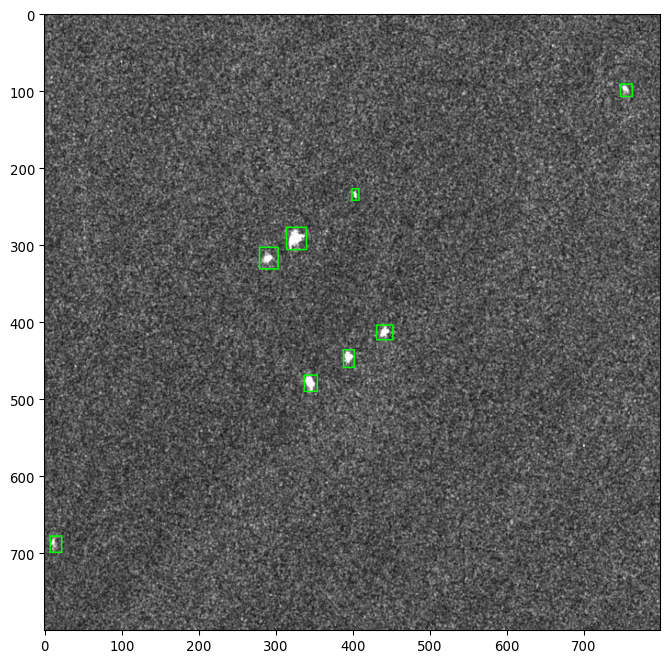

In [ ]:
# get bounding boxes coordinates from grouped data frame and write into array
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
image = imageio.imread(images_path + 'vessel/' + image_name + '.jpg')
# pass the array of bounding boxes coordinates to the imgaug library
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
# display the image and draw bounding boxes
ia.imshow(bbs.draw_on_image(image, size=2))

## Subset test dataset with offshore images

The original data from Zhang et al. 2020 has two .txt files where the test data set has been splited for offshore images and inshore images in those cases where the image included some land areas. In order to evaluate the performance differences between both cases, we will filter the original .txt and keep only those file names that contain ship instances.

In [ ]:
# RUN ONLY ONCE
# save those unique names that are in test_offshore.txt and test.txt to a new txt file
with open(imagesets + "original/test_offshore.txt") as f:
    lines = f.readlines()
    for line in lines:
        if line in open(imagesets + "/test.txt").read():
            with open(imagesets + "/test_offshore_in_test.txt", "a") as myfile:
                myfile.write(line)

# Do the same for test_inshore.txt
with open(imagesets + "original/test_inshore.txt") as f:
    lines = f.readlines()
    for line in lines:
        if line in open(imagesets + "/test.txt").read():
            with open(imagesets + "/test_inshore_in_test.txt", "a") as myfile:
                myfile.write(line)


In [ ]:
print(count_lines("data/imagesets/test_inshore_in_test.txt"))
print(count_lines("data/imagesets/test_offshore_in_test.txt"))
print(count_lines("data/imagesets/test_inshore_in_test.txt")+count_lines("data/imagesets/test_offshore_in_test.txt"))
print(count_lines("data/imagesets/test.txt"))

117
618
735
736
